# [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/kernels?sortBy=hotness&group=everyone&pageSize=20&language=Python&competitionId=8540)

Can you detect fraudulent click traffic for mobile app ads?

## Disclaimer

This notebook has crashed every machine I ran it on with less than 120.0 GBs of RAM. I specifically was using a AWS EC2 x1e.xlarge instance

_I'm sorry_

## EDA

In [1]:
# ensure our graphs are displayed inline
%matplotlib inline

In [2]:
import os
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from concurrent.futures import ProcessPoolExecutor
from sklearn.ensemble import RandomForestRegressor

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
random_seed = 42

In [4]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

<Figure size 864x360 with 0 Axes>

We'll first look at the data files we've downloaded for the challenge

In [ ]:
print("File sizes")

for f in os.listdir("data/"):
    if "zip" not in f and f.endswith("csv"):
        print(f.ljust(30) + str(round(os.path.getsize("data/" + f) / 1000000, 2)) + " MB")

While we'd like to work with a small data set, like `train_sample.csv`, its just too small to represent the entire data set `train.csv`. We'll load the entire train set into a DataFrame so we can analyze it

In [5]:
# data_set = "data/train_sample.csv"
data_set = "data/train.csv"

train = pd.read_csv(data_set) # , dtype=dtype, parse_dates=parse_dates)

Now lets peak at the first few values of the data

In [ ]:
train.head()

In [ ]:
train.tail()

We'll notice that the features `ip`, `app`, `device`, `os` and `channel` and our class variable `is_attributed` are categorical as they're encoded to anonymize and preserve privacy. Therefore we'll want to ensure we set their type to non-numerical to avoid nonense operations on the data like calculating their `mean`, `median`, ... etc.

In [6]:
categorical_columns = ["ip", "app", "device", "os", "channel", "is_attributed"]

for column in categorical_columns:
    train[column] = train[column].astype('category')

At this point we'll covert the `click_time` and `attributed_time` columns into date time fields, as they represent time series data

In [7]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

Now we'll get a high level look at the training data set

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
plt.figure(figsize=(10, 6))
cols = ["ip", "app", "device", "os", "channel"]
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel="Feature", ylabel="log(unique count)", title="Number of unique values per feature")

# Places the value just above the column
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            uniq,
            ha="center") 

From our knowledge of the competion, every row in the DataFrame that has a set value of `is_attributed` should also have a value for `attributed_time`. Lets test that belief

In [ ]:
# Grabs a subset of the DataFrame and then further grabs only the rows where `is_attributed` is set, then calculating the counts
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

### Quick Take Aways

- The training set takes place over two days, two hours and eleven seconds
- Out of 184,903,890 rows, only 456,846 of them have an `attributed_time` values of `1.0`
  - This means only 456,846 out of 184,903,890 ad clicks resulted in a download
  - Which is about 0.0025 % of the clicks
- There is atleast one ip adress that triggers an ad click over fifty thousand times
  - Seems strange that one ip address would click that often in a span of just 4 days
  - Does that mean that ip address encoded is not device id, but network id? (explore this below)

Our data is incredilby unbalanced. We're visualizing here the small percents of ad clicks resulting in a download.

In [ ]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Explore ip counts: _Check if multuiple ips have any downloads_

Since we don't know what `ip` is actually encoding, we're going to see if we can make any inferences based on the `value_counts()` of tha data set.

One might think that each `ip` equates to a single user, but we'll see that this is probably not the case.

In [ ]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

In [ ]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

In [ ]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

In [ ]:
train[train['is_attributed']==1].ip.describe()

Here we can see up to `2340` downloads for a single IP address. This IP must be for some sort of network with multiple devices.

In [ ]:
# convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

### Conversion rates over Counts of 300 most popular IPs

In [ ]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

There does not seem to be a correlation between the popularity of an `ip` and its `click_count`

### Conversions by App

We'll check out the 100 most popular apps by click count.

In [ ]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

We see here a very large difference in the `click_count` per `app`. The largest `click_count` is thirty three million for one app.

We can explain the proportion flucuation as the `click_count` reduces as each click will have a larger impact.

### Conversions by OS

Now we'll look at the top 100 operating systems by `click_count`

In [ ]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Agin, we can see ratio is very low but as the `click_count` reduces the ratio starts fluxuating more.

### Conversions by Device

In [ ]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

### Conversions by Channel

In [ ]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

There are some random peaks for some `channel`s at high `click_count`s, but generally we're seeing the same situation as above.

### Checking for Time Patterns

We're now going to inspect hourly patterns by rounding the `click_time` down to an hour of the samme day.

In [8]:
#convert click_time and attributed_time to time series
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

In [ ]:
#round the time to nearest hour
train['click_rnd']=train['click_time'].dt.round('H')  

#check for hourly patterns
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There's clearly a pattern in frequency of clicks based on time of day, but there is no clear hourly time pattern in ratios.

Now we'll create a new feature by extracting the hour of the day, for every day. We'll be checking if the combined if there's a trend specifically based on the hour throughout the entire training set.

In [ ]:
#extract hour as a feature
train['click_hour']=train['click_time'].dt.hour

In [ ]:
train.head(7)

Now we'll inspect the clicks by hour:

In [ ]:
train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

Also, number of conversions by hours:

In [ ]:
train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

Its hard to compare the clicks and conversions per hour, so lets overlay the two Lineplots to see if there's any easy to see correlation:

In [ ]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

The only take away I have from this graph is the significant down trend in both Proportion Converted and Click Count that starts around the twelth hour.

I am currently unsure what time this would actually represent, nor if it even matters.

We'll produce one more graphic to see the `click_hour` vs Converted Ratio, with an error bar:

In [ ]:
sns.barplot('click_hour', 'is_attributed', data=train)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

### Look intro `attributed_time`

Now we'll look specifically at conversions that did take place. We'll explicitly be looking at how much time passed from the original ad click to the actual download.

In [9]:
train['time_pass'] = train['attributed_time']-train['click_time']

# peek at the data to ensure its correct
train[train['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_pass
103,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,16:36:12
1504,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,18:05:20
1798,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,07:40:48
2102,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1,08:55:26
3056,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1,07:04:50
3220,82917,19,0,24,210,2017-11-06 16:00:04,2017-11-07 00:21:50,1,08:21:46
3939,126647,72,1,6,101,2017-11-06 16:00:05,2017-11-06 16:01:18,1,00:01:13
5282,57546,29,1,41,213,2017-11-06 16:00:07,2017-11-06 16:03:51,1,00:03:44
5377,189682,35,1,13,21,2017-11-06 16:00:07,2017-11-06 23:37:17,1,07:37:10
5438,24200,19,88,24,213,2017-11-06 16:00:07,2017-11-07 04:18:51,1,12:18:44


In [18]:
train['time_pass'].describe()

count                  456846
unique                  43460
top       1970-01-01 00:00:34
freq                     6570
first     1970-01-01 00:00:00
last      1970-01-01 23:55:10
Name: time_pass, dtype: object

We see here that the longest time it took to go from clicking an ad to downloading the app was about twenty four hours, while the shortest time was zero seconds.

Both this minimum value and maximum value seem incredibly fishy.

I was reading through the comments on [yuliagm's post](https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns) and saw the community discussing what exacty the `attributed_time` and `click_time` might represent. User [shlomis](https://www.kaggle.com/shlomis) suggests that the size of the app would affect the installation time, as the timestamp wouldn't get triggered till the end of the download. So for example, a 100MB app would take longer than say a 10MB app, but [Yuliagm](https://www.kaggle.com/yuliagm) shot that idea down.

Additionally, [Peter](https://www.kaggle.com/pestipeti) suggested that the download/install tracking code is in the application itself, atleast for Android, and therefore the `attributed_time` will not get triggered until the user opens the application for the first time. If this was true, this would explain the rather large `time_pass` columns we calculated, as someone could wait almost twenty four hours before opening their app. I find this fishy, as I'd expect the max to be even larger than this. 

At this point, I nor does anyone I've seen on Kaggle have a definitive idea what these columns represent.

### `click_time` Pandas.DateTime Transformation

To make training our model(s) easier, we'll translate our two `datetime64` columns, `click_time` and `attributed_time`, to separate columns that can be represented with `int`s.

Specifically:
* year
* month
* day
* hour
* minute
* second

We'll be doing this process multicored, as it takes about ten minutes to run on my EC2 `r3.2xlarge`

In [13]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_pass
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,NaT
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0,NaT
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0,NaT
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0,NaT
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0,NaT


In [ ]:
train["click_time_year"], train["click_time_month"], train["click_time_day"], train["click_time_hour"], train["click_time_minute"], train["click_time_second"] = zip(*train["click_time"].apply(lambda row: (row.year, row.month, row.day, row.hour, row.minute, row.second)))

In [ ]:
train.head()

Now lets check the first couple of rows to ensure we separated the values correct:

In [ ]:
train.head()

Things look good! 

Now we'll drop the old column:

In [19]:
train = train.drop(["click_time"], axis=1)
train.head()

,ip,app,device,os,channel,attributed_time,is_attributed,time_pass
0,83230,3,1,13,379,NaT,0,NaT
1,17357,3,1,19,379,NaT,0,NaT
2,35810,3,1,13,379,NaT,0,NaT
3,45745,14,1,13,478,NaT,0,NaT
4,161007,3,1,13,379,NaT,0,NaT


### Avoiding Data Leakage

To avoid data leakage, our models will not be using the `attributed_time` columns, as this is directly correlated to the `is_attributed` and would result in a score of 100%. Additionaly, the `attributed_time` does not exist in the testing set.

Lets remove `attributed_time`:

In [20]:
train = train.drop(["attributed_time"], axis=1)
train.head()

,ip,app,device,os,channel,is_attributed,time_pass
0,83230,3,1,13,379,0,NaT
1,17357,3,1,19,379,0,NaT
2,35810,3,1,13,379,0,NaT
3,45745,14,1,13,478,0,NaT
4,161007,3,1,13,379,0,NaT


Additionally, we'll be removing `time_pass`, as it was built using `attributed_time`:

In [22]:
train = train.drop(["time_pass"], axis=1)
train.head()

,ip,app,device,os,channel,is_attributed
0,83230,3,1,13,379,0
1,17357,3,1,19,379,0
2,35810,3,1,13,379,0
3,45745,14,1,13,478,0
4,161007,3,1,13,379,0


We're now ready to start building models.

## Model

### Logistic Regression

Are first model we'll use is strictly logistic regression. Our plan here was to go from nothing to something as quickly as possible and than iterate and see if we can increase our ROC curve value.

First we'll get a list of all our features, `x`, and our class variable, `y`.

In [23]:
# Get our x and y column names
y_column = ["is_attributed"]
x_columns = [i for i in train if i not in y_column]

x = train[x_columns]
y = train[y_column]

### Our Metric Functions

In [24]:
def roc_curve(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

### Split Our Data Set Without Stratification

So we can ensure we're testing on data we didn't train on

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Creating Our Baseline

We'll want to be able to compare to guessing `is_attributed` is no for all of them to see how well we perform:

In [26]:
1.0 - y_test.sum() / len(y_test)

is_attributed    0.997531
dtype: float64

This means we should get 0.9974 accuracy by guessing `is_attributed` is $0$ for all values

In [27]:
metrics.roc_auc_score(y_test, [0 for _ in range(len(y_test))])

0.5

In [28]:
metrics.accuracy_score(y_test, [0 for _ in range(len(y_test))])

0.9975306630920528

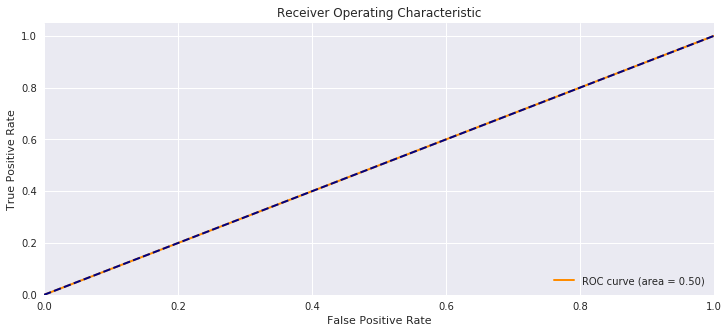

In [29]:
roc_curve(y_test, [0 for _ in range(len(y_test))])

This Kaggle competition uses roc auc to score, so our models need to be $0.5$

#### Simple Logistic Regression

Our first attempt will simply use every column as a feature.

##### Baesline

In [30]:
x_train

,ip,app,device,os,channel
52321245,131161,3,1,34,489
110322122,21120,18,1,13,107
124594344,29984,13,1,19,477
71758022,7944,12,1,26,265
25085447,211667,9,1,25,244
168841064,82212,18,1,25,107
90427509,88063,26,1,19,477
141826767,111025,3,2,22,280
8912792,9946,1,1,19,134
81745909,97766,18,1,13,134


In [ ]:
y_train

In [ ]:
y_train.ravel()

In [ ]:
baseline_lr = LogisticRegression(random_state=random_seed)
baseline_lr.fit(x_train, y_train.ravel())

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
metrics.roc_auc_score(y_test, baseline_lr.predict_proba(x_test)[:,1])

In [ ]:
metrics.accuracy_score(y_test, baseline_lr.predict(x_test))

With the bare minimum work, we're beating our base line, which is great news. Lets take a look at our ROC curve visually:

In [ ]:
roc_curve(y_test, baseline_lr.predict_proba(x_test)[:,1])

##### Random Search CV

Now we're going to brute force our way through finding the optimal parameters for our Logisitic Regression model, with our goal being that our ROC AUC score is higher than our Base Line Linear Regression.

With the bare minimum work, we're beating our base line, which is great news. Lets take a look at our ROC curve visually:

##### Split Our Data With Statisfication

Ensure that our training and test sets have equal proportions of our class variables.

In [ ]:
# TODO write code to this AND re score

##### Up Sample Class Variable With SMOTE

Ensures we have a data set with closer to 50/50 True/False class variable.

In [ ]:
# TODO write code to either up sample or down sample AND rescore, carying over the stratification work

### Random Forest

For fun, lets try using a Random Forest and see how well it performs.

##### Baseline

With the bare minimum work, we're beating our base line, which is great news. Lets take a look at our ROC curve visually:

##### Stratify

##### Random Search CV

Now we're going to brute force our way through finding the optimal parameters for our Logisitic Regression model, with our goal being that our ROC AUC score is higher than our Baseline Random Forest

With the bare minimum work, we're beating our base line, which is great news. Lets take a look at our ROC curve visually:

## References

* https://www.kaggle.com/anokas/talkingdata-adtracking-eda
  - for usage of inspecting files before choosing which to use for EDA
* https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns
  - for excellent EDA